# Berlin Climate Analysis 1949-2022

This notebook examines the weather data of Berlin from 1949-2022, sourced from the European Climate Assessment & Dataset (ECA&D). Through data visualization, we explore the yearly, monthly, and/or daily median temperature (°C), precipitation (mm), sea level pressure (hPa), sunshine duration (hours), and wind speed (m/s) to identify trends and relationships. Additionally, this notebook showcases basic data wrangling techniques, missing value imputation, and some data visualization.

## Data Preparation

### Importing Modules
The necessary modules are imported to read and manipulate the data.

In [435]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import math

###  Read and Merge Data into a DataFrame
The weather data is loaded from five different files into separate dataframes and concatenated into one dataframe. The columns are renamed, the index is set to the date, and the data is filtered to only include dates from 1949 to 2022.

In [436]:
file_names = ['berlin_avg_temp', 'berlin_precipitation', 'berlin_sea_level', 'berlin_sunshine', 'berlin_wind_speed']
dfs = []

for file_name in file_names:
    df = pd.read_csv(f'data/eca/{file_name}.txt', delimiter=',').rename(columns=str.strip)
    df = df[(df['DATE'] >= 19490101) & (df['DATE'] <= 20221231)].set_index('DATE')
    df.index = pd.to_datetime(df.index, format='%Y%m%d')
    dfs.append(df)
df = pd.concat(dfs, axis=1)
df = df[['TG', 'RR', 'PP', 'SS', 'FG']].rename_axis(None)
df = df.rename(columns={'TG': 'temp', 'RR': 'prec', 'PP': 'pres', 'SS': 'sunh', 'FG': 'wind'})
df_copy = df.copy() # make a copy of the original data for later
print(df.head())

            temp  prec   pres  sunh  wind
1949-01-01    36     0   9964     0 -9999
1949-01-02    35    60   9939     0 -9999
1949-01-03    34    30  10022    35 -9999
1949-01-04    14     0  10129    43 -9999
1949-01-05    18     0  10246    20 -9999


### Preparing Data for Time Series Analysis
The date column is converted to datetime and used as the index for the dataframe to enable easy analysis and visualization of the weather data over time.

In [437]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['day_no'] = df.index.dayofyear
print(df.tail())

            temp  prec   pres  sunh  wind  year  month  day  day_no
2022-12-27    42     0  10207    22    46  2022     12   27     361
2022-12-28    63    15  10154    13    46  2022     12   28     362
2022-12-29   100    18  10055    24    48  2022     12   29     363
2022-12-30    76    20  10110    62    41  2022     12   30     364
2022-12-31   148     0  10076     6    59  2022     12   31     365


## Handling Missing Values

### Linear Interpolation
Linear interpolation can be used to handle missing data in climate data sets because it assumes a linear relationship between two adjacent data points. In this code below, the function iterates through the first 4 columns of the dataframe and replaces any values equal to -9999 with the average of the previous and next year's values, then returns the updated dataframe.

In [438]:
def replace_missing_values(df):
    
    for col in df.columns[0:4]:
        missing_rows = df.loc[df[col] == -9999]
        if len(missing_rows) == 0:
            continue
        for index, row in missing_rows.iterrows():
            prev_year_val = None
            year = index.year
            while prev_year_val is None and year >= df.index.min().year:
                try:
                    prev_year_val = df.loc[f'{year-1}-{index.month}-{index.day}'][col]
                except KeyError:
                    # Handle leap year
                    if index.month == 2 and index.day == 29:
                        prev_year_val = df.loc[f'{year-1}-02-28'][col]
                    year -= 1
            next_year_val = None
            year = index.year
            while next_year_val is None and year <= df.index.max().year:
                try:
                    next_year_val = df.loc[f'{year+1}-{index.month}-{index.day}'][col]
                except KeyError:
                    # Handle leap year
                    if index.month == 2 and index.day == 29:
                        next_year_val = df.loc[f'{year+1}-03-01'][col]
                    year += 1
            if prev_year_val is None:
                prev_year_val = 0
            if next_year_val is None:
                next_year_val = 0
            df.at[index, col] = (prev_year_val + next_year_val) / 2
    return df

replace_missing_values(df)

,temp,prec,pres,sunh,wind,year,month,day,day_no
1949-01-01,36,0,9964.0,0,-9999,1949,1,1,1
1949-01-02,35,60,9939.0,0,-9999,1949,1,2,2
1949-01-03,34,30,10022.0,35,-9999,1949,1,3,3
1949-01-04,14,0,10129.0,43,-9999,1949,1,4,4
1949-01-05,18,0,10246.0,20,-9999,1949,1,5,5
...,...,...,...,...,...,...,...,...,...
2022-12-27,42,0,10207.0,22,46,2022,12,27,361
2022-12-28,63,15,10154.0,13,46,2022,12,28,362
2022-12-29,100,18,10055.0,24,48,2022,12,29,363
2022-12-30,76,20,10110.0,62,41,2022,12,30,364


### Median Imputation

The earlier approach of filling in missing values by interpolation relies on the assumption that there is a smooth temporal relationship between data points. In the case of wind speed, the absence of reliable data for wind speed from 1949-1973, was filled with the missing values using the median.

In [439]:
df['wind'] = df['wind'].replace(-9999, np.nan)
df['wind'].fillna(df['wind'].median(), inplace=True)
print(df)

            temp  prec     pres  sunh  wind  year  month  day  day_no
1949-01-01    36     0   9964.0     0  36.0  1949      1    1       1
1949-01-02    35    60   9939.0     0  36.0  1949      1    2       2
1949-01-03    34    30  10022.0    35  36.0  1949      1    3       3
1949-01-04    14     0  10129.0    43  36.0  1949      1    4       4
1949-01-05    18     0  10246.0    20  36.0  1949      1    5       5
...          ...   ...      ...   ...   ...   ...    ...  ...     ...
2022-12-27    42     0  10207.0    22  46.0  2022     12   27     361
2022-12-28    63    15  10154.0    13  46.0  2022     12   28     362
2022-12-29   100    18  10055.0    24  48.0  2022     12   29     363
2022-12-30    76    20  10110.0    62  41.0  2022     12   30     364
2022-12-31   148     0  10076.0     6  59.0  2022     12   31     365

[27028 rows x 9 columns]


### Data Units Adjustment

The data units reported by ECA&D were adjusted by dividing the values by 10 to enable accurate interpretation and analysis of the data.

In [440]:
for col in df.columns[0:4]:
    df[col] = df[col] / 10
print(df)

            temp  prec    pres  sunh  wind  year  month  day  day_no
1949-01-01   3.6   0.0   996.4   0.0  36.0  1949      1    1       1
1949-01-02   3.5   6.0   993.9   0.0  36.0  1949      1    2       2
1949-01-03   3.4   3.0  1002.2   3.5  36.0  1949      1    3       3
1949-01-04   1.4   0.0  1012.9   4.3  36.0  1949      1    4       4
1949-01-05   1.8   0.0  1024.6   2.0  36.0  1949      1    5       5
...          ...   ...     ...   ...   ...   ...    ...  ...     ...
2022-12-27   4.2   0.0  1020.7   2.2  46.0  2022     12   27     361
2022-12-28   6.3   1.5  1015.4   1.3  46.0  2022     12   28     362
2022-12-29  10.0   1.8  1005.5   2.4  48.0  2022     12   29     363
2022-12-30   7.6   2.0  1011.0   6.2  41.0  2022     12   30     364
2022-12-31  14.8   0.0  1007.6   0.6  59.0  2022     12   31     365

[27028 rows x 9 columns]


## Data Findings with Visualization
Here we are going to explore data visualization for each variable to see further see the trends. In this section, we are going to use yearly and monthly median (since media is less sensitive to outliers compared to other measures of central tendency).

### Temperature
Celsius is commonly used as the unit of measurement. The first plot utilizes climate stripes help us visualize how temperature changes over time, where each stripe represents a year. The second plot is a heatmap using coolwarm colors to illustrate the temperature range. The third plot utilizes both line and scatter plots to highlight the transition from cooler to warmer temperatures over the past 50 years.


Warmest years in [2018, 2014, 1949] reaching [12.2, 11.9, 11.6] °C,
Coolest years in [1973, 1956, 1958] reaching [8.0, 8.25, 8.4] °C.



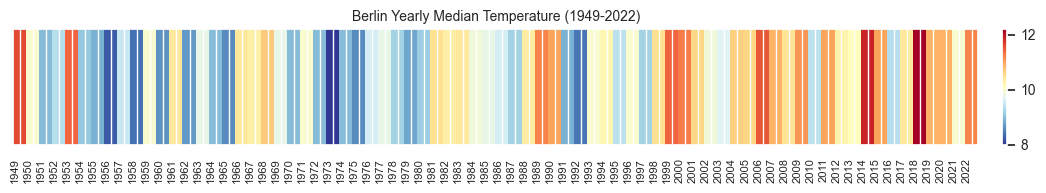

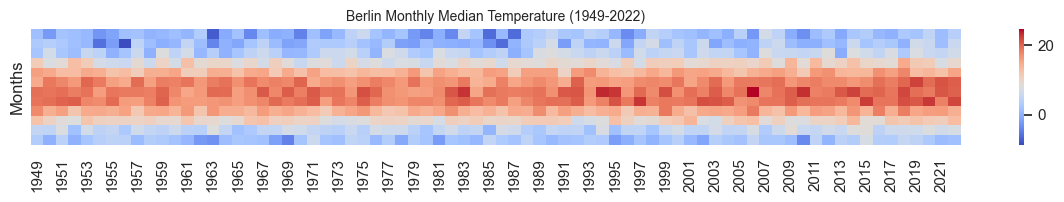

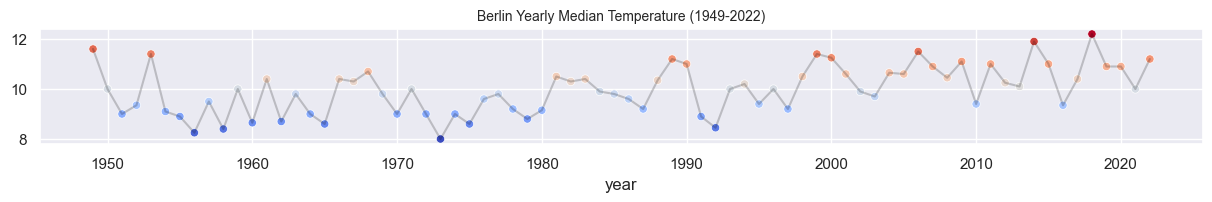

In [441]:
years = range(1949, 2023)

df_temp = df.groupby('year')['temp'].median()
df_temp_list = df_temp.tolist()

print(f"""
Warmest years in {df_temp.nlargest(3).index.tolist()} reaching {df_temp.nlargest(3).tolist()} °C,
Coolest years in {df_temp.nsmallest(3).index.tolist()} reaching {df_temp.nsmallest(3).tolist()} °C.
""")
      
# First Plot
fig, ax = plt.subplots(figsize=(15, 1.5))
cmap = plt.cm.get_cmap('RdYlBu_r')
norm = plt.Normalize(np.min(df_temp_list), np.max(df_temp_list))
image = ax.imshow([df_temp_list], cmap=cmap, aspect='auto', norm=norm)
cbar = plt.colorbar(image, ax=ax, orientation='vertical', pad=0.02)
cbar.ax.tick_params(labelsize=10)
cbar.ax.tick_params(axis='x', pad=10)  # add a margin on top
ax.set_xticks(np.linspace(0, len(df_temp_list)-1, len(years)))
ax.set_xticklabels(years, fontsize=8, rotation=90, ha='right')
ax.set_yticks([])
ax.set_ylabel('')
plt.title('Berlin Yearly Median Temperature (1949-2022)', fontsize=10)

df_monthly_temp = df.groupby(['year', 'month'])['temp'].median().unstack().T

# Second Plot
fig, ax = plt.subplots(figsize=(15, 1.5))
sns.heatmap(df_monthly_temp, cmap='coolwarm', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Months')
ax.set_yticks([])
plt.title('Berlin Monthly Median Temperature (1949-2022)', fontsize=10)

#Third Plot
sns.set(style="darkgrid")
plt.figure(figsize=(15, 1.5))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.lineplot(data=df_temp, x="year", y=df_temp.values, color='black', label='1949-2022', alpha=0.2)
sns.scatterplot(data=df_temp, x="year", y=df_temp.values, hue=df_temp.values, label='1949-2022', palette=cmap)
plt.title('Berlin Yearly Median Temperature (1949-2022)', fontsize=10)
plt.legend().remove()
plt.show()


### Precipitation
Precipitation (mm) in the climate data refers to the amount of both snow and rainfall measured in millimeters. A heatmap visualisation can be used to represent precipitation data, where the darkest hue indicates a higher amount of precipitation.

Berlin had the highest precipitation amount [(1974, 12), (1976, 1), (1988, 2)]
with [3.0, 2.6, 2.2]mm. Between 1949 and 2022, Berlin experienced little 
to none precipitation in 511 months.


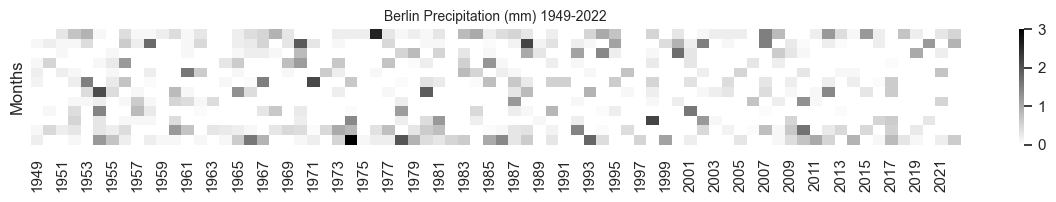

In [442]:
df_monthly_prec = df.groupby(['year', 'month'])['prec'].median().unstack().T

num_zeros = df_monthly_prec.eq(0).sum().sum()
print(f"""Berlin had the highest precipitation amount {df_monthly_prec.unstack().nlargest(3).index.tolist()}
with {df_monthly_prec.unstack().nlargest(3).tolist()}mm. Between 1949 and 2022, Berlin experienced little 
to none precipitation in {num_zeros} months.""")

# Create heatmap
fig, ax = plt.subplots(figsize=(15, 1.5))
sns.heatmap(df_monthly_prec, cmap='gray_r', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Months')
ax.set_yticks([])
plt.title('Berlin Precipitation (mm) 1949-2022', fontsize=10)
plt.show()

### Sea Level Pressure
Sea level pressure (hPa) is a metric used to describe the atmospheric pressure at sea level, which is typically around 1013 hPa. The bar plot displays sea level pressure (hPa) for the years 1953-2022 in Berlin, representing the trend per decade, with the darkest shade representing the most recent decade and the lightest shade representing the oldest.

From 1953-1962, the highest sea level pressure reported 1034.2 hPa occurred in Year 2 and month 1956 while the lowest sea level pressure reported was 1004.0 hPa occurred in Year 1 and month 1956.
From 1963-1972, the highest sea level pressure reported 1031.2 hPa occurred in Year 1 and month 1970 while the lowest sea level pressure reported was 1003.6 hPa occurred in Year 12 and month 1970.
From 1973-1982, the highest sea level pressure reported 1031.65 hPa occurred in Year 2 and month 1977 while the lowest sea level pressure reported was 1001.0 hPa occurred in Year 12 and month 1977.
From 1983-1992, the highest sea level pressure reported 1031.1 hPa occurred in Year 1 and month 1988 while the lowest sea level pressure reported was 1006.4 hPa occurred in Year 5 and month 1988.
From 1993-2002, the highest sea level pressure reported 1029.4 hPa occurred in Year 2 and month 1995 while the lowest sea level pressure reported was 1002.8 hPa occurred in Year 12 and month 1995.
From 2003-2012, 

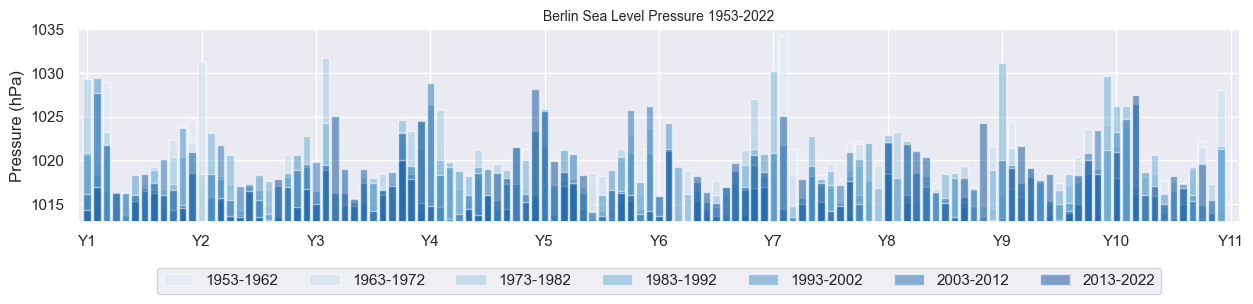

In [443]:
df_pres_1950 = df.loc['1953-01-01':'1962-12-31'].groupby(['year', 'month'])['pres'].median().unstack()
df_pres_1960 = df.loc['1963-01-01':'1972-12-31'].groupby(['year', 'month'])['pres'].median().unstack()
df_pres_1970 = df.loc['1973-01-01':'1982-12-31'].groupby(['year', 'month'])['pres'].median().unstack()
df_pres_1980 = df.loc['1983-01-01':'1992-12-31'].groupby(['year', 'month'])['pres'].median().unstack()
df_pres_1990 = df.loc['1993-01-01':'2002-12-31'].groupby(['year', 'month'])['pres'].median().unstack()
df_pres_2000 = df.loc['2003-01-01':'2012-12-31'].groupby(['year', 'month'])['pres'].median().unstack()
df_pres_2010 = df.loc['2013-01-01':'2022-12-31'].groupby(['year', 'month'])['pres'].median().unstack()

pres_1950_list = df_pres_1950.values.flatten().tolist()
pres_1960_list = df_pres_1960.values.flatten().tolist()
pres_1970_list = df_pres_1970.values.flatten().tolist()
pres_1980_list = df_pres_1980.values.flatten().tolist()
pres_1990_list = df_pres_1990.values.flatten().tolist()
pres_2000_list = df_pres_2000.values.flatten().tolist()
pres_2010_list = df_pres_2010.values.flatten().tolist()

dfs_pres = [df_pres_1950, df_pres_1960, df_pres_1970, df_pres_1980, df_pres_1990, df_pres_2000, df_pres_2010]
years = ['1953-1962', '1963-1972', '1973-1982', '1983-1992', '1993-2002', '2003-2012', '2013-2022']

#Just a loop to print the highest and lowest pressure for each decade
for i in range(len(dfs_pres)):
    print(f"From {years[i]}, the highest sea level pressure reported {round(dfs_pres[i].max().max(), 2)} hPa occurred in Year {dfs_pres[i].max().idxmax()} and month {dfs_pres[i].idxmax(axis=1).idxmax()} while the lowest sea level pressure reported was {round(dfs_pres[i].min().min(), 2)} hPa occurred in Year {dfs_pres[i].min().idxmin()} and month {dfs_pres[i].idxmax(axis=1).idxmax()}.")

sns.set(style="darkgrid")
colors = sns.color_palette("Blues", n_colors=7)
fig, ax = plt.subplots(figsize=(15, 2.5))
ax.bar(x=np.arange(len(pres_1950_list)), height=pres_1950_list, color=colors[0], alpha=0.5, label='1953-1962')
ax.bar(x=np.arange(len(pres_1960_list)), height=pres_1960_list, color=colors[1], alpha=0.5, label='1963-1972')
ax.bar(x=np.arange(len(pres_1970_list)), height=pres_1970_list, color=colors[2], alpha=0.5, label='1973-1982')
ax.bar(x=np.arange(len(pres_1980_list)), height=pres_1980_list, color=colors[3], alpha=0.5, label='1983-1992')
ax.bar(x=np.arange(len(pres_1990_list)), height=pres_1990_list, color=colors[4], alpha=0.5, label='1993-2002')
ax.bar(x=np.arange(len(pres_2000_list)), height=pres_2000_list, color=colors[5], alpha=0.5, label='2003-2012')
ax.bar(x=np.arange(len(pres_2010_list)), height=pres_2010_list, color=colors[6], alpha=0.5, label='2013-2022')
ax.set_xticks(np.arange(0, 121, 12), ['Y{}'.format(i+1) for i in range(11)])
ax.set_title('Berlin Sea Level Pressure 1953-2022', fontsize=10)
ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=7)
ax.set_ylim(1013, 1035)
ax.set_xlim(-1, 121)
ax.set_ylabel("Pressure (hPa)")
plt.show()


### Sunshine Duration
Sunshine hours refer to the total time during the day when the sun is above the horizon and is visible to an observer. It is the duration between sunrise and sunset when the sunlight reaches the ground without obstruction. It should not be confused with daytime as daytime is a more general measure of the length of the period between sunrise and sunset. In this plot, we included an additional heat map using a yellow-orange color map. In the trend below, we expect summer season to have more sunshine duration hours.


Peak Sunshine years in [2018, 1953, 1982] with [5.8, 5.5, 5.2] hours,
Lowest Sunshine years in [2013, 2010, 1966] with [2.1, 2.2, 2.5] hours.



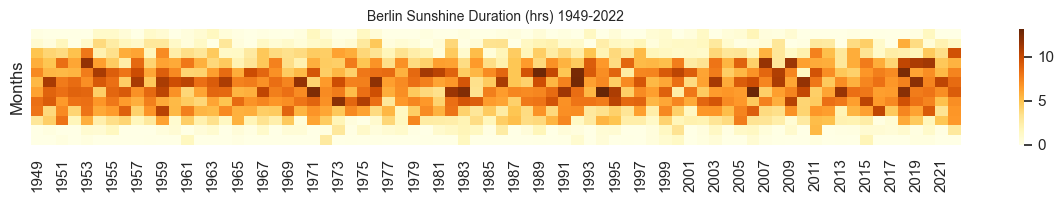

In [444]:
df_sunh = df.groupby('year')['sunh'].median()
print(f"""
Peak Sunshine years in {df_sunh.nlargest(3).index.tolist()} with {df_sunh.nlargest(3).tolist()} hours,
Lowest Sunshine years in {df_sunh.nsmallest(3).index.tolist()} with {df_sunh.nsmallest(3).tolist()} hours.
""")

df_monthly_sunh = df.groupby(['year', 'month'])['sunh'].median().unstack().T

# Create heatmap
fig, ax = plt.subplots(figsize=(15, 1.5))
sns.heatmap(df_monthly_sunh, cmap='YlOrBr', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Months')
ax.set_yticks([])
plt.title('Berlin Sunshine Duration (hrs) 1949-2022', fontsize=10)
plt.show()


### Wind Speed

The windspeed (m/s) can imply various aspects of climate and weather, such as the strength and direction of air masses, the distribution of heat and moisture, and the formation and movement of weather systems. The barplot graph and heat map did not provide much insight into the data (using yearly, monthly median), while the scatter plot revealed that the strongest wind speeds occurred in the first and fourth quarters of the year, with darker hues indicating the most recent years. 


Strongest wind speed in [1974, 1998, 1979] reaching [42.0, 40.0, 39.0] m/s,
Weakest wind speed in [2016, 2020, 2021] reaching [32.0, 33.0, 33.0] m/s.



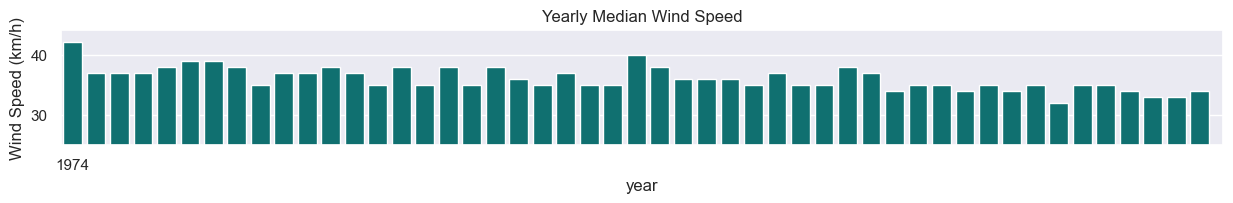

In [477]:
years = range(1974, 2023)
df_wind = df.loc['1974-01-01':'2022-12-31'].reset_index(drop=True)
df_wind = df_wind.groupby('year')['wind'].median()

print(f"""
Strongest wind speed in {df_wind.nlargest(3).index.tolist()} reaching {df_wind.nlargest(3).tolist()} m/s,
Weakest wind speed in {df_wind.nsmallest(3).index.tolist()} reaching {df_wind.nsmallest(3).tolist()} m/s.
""")

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15, 1.5))
sns.barplot(x=df_wind.index, y=df_wind.values, color='teal')
plt.title('Yearly Median Wind Speed')
ax.set_xticks(np.linspace(0, len(years), 10))
ax.set_ylim(25, ax.get_ylim()[1]) # set y-axis limit to start from 25
plt.ylabel('Wind Speed (km/h)')
plt.show()


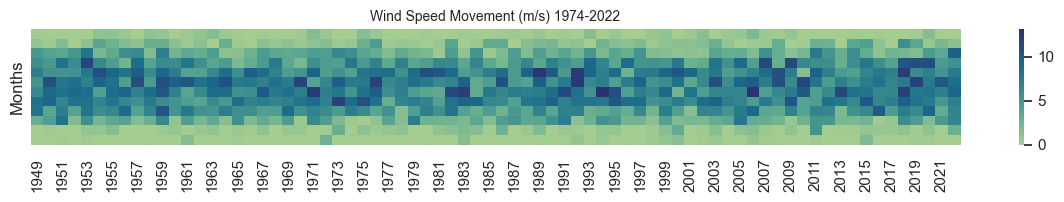


Strongest wind speed reported on [1976, 1993, 1999] with [145.0, 122.0, 121.0] m/s,
Weakest wind speed reported on [2001, 2001, 1983] with [0.0, 0.0, 4.0] m/s



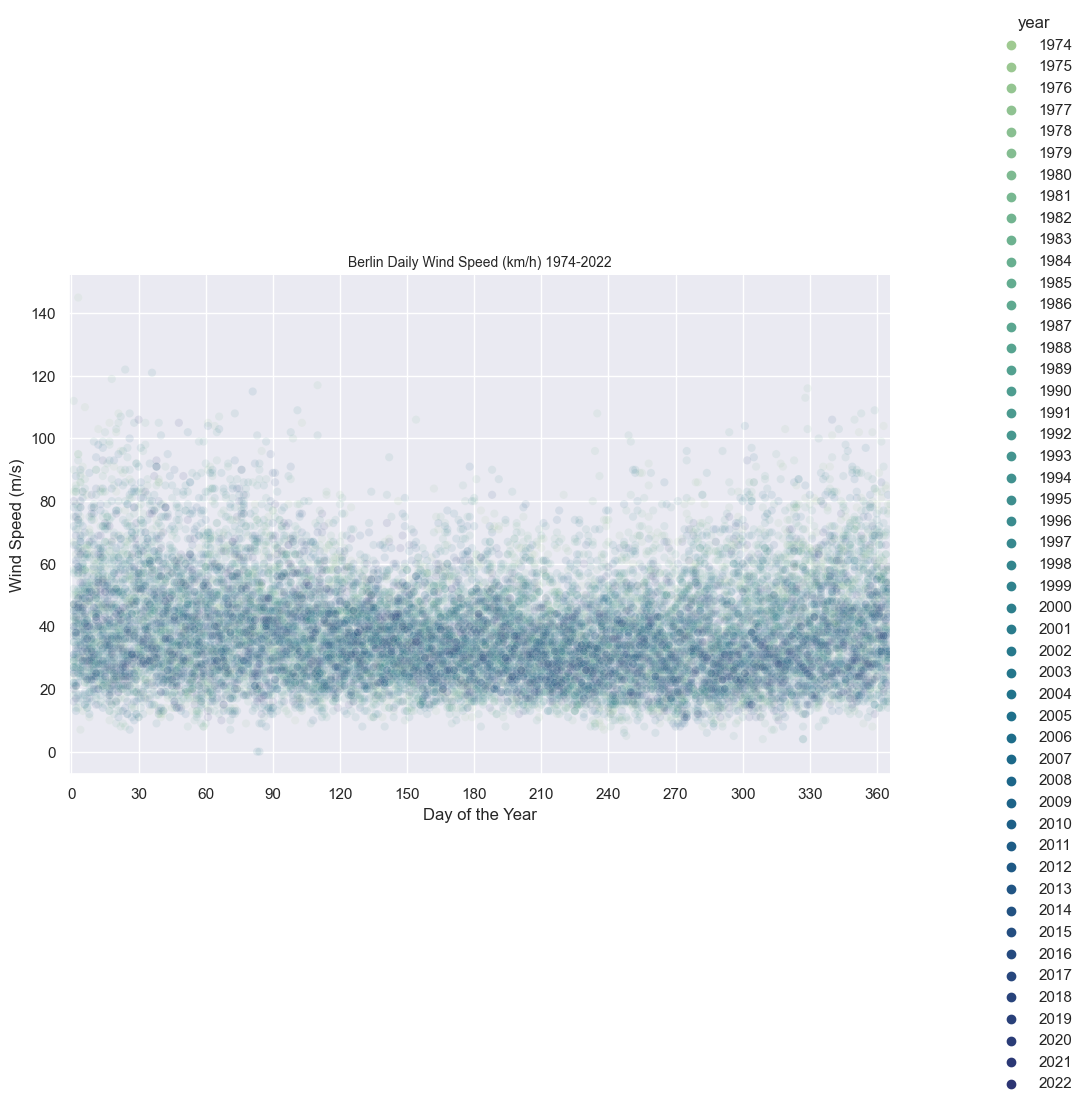

In [484]:
df_monthly_wind = df.loc['1974-01-01':'2022-12-31'].reset_index(drop=True)
df_monthly_wind = df.groupby(['year', 'month'])['wind'].median().unstack().T

# Create heatmap
fig, ax = plt.subplots(figsize=(15, 1.5))
sns.heatmap(df_monthly_sunh, cmap='crest', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Months')
ax.set_yticks([])
plt.title('Wind Speed Movement (m/s) 1974-2022', fontsize=10)
plt.show()


df_daily_wind = df.loc['1974-01-01':'2022-12-31'].reset_index(drop=True)
df_daily_wind = df_daily_wind[['year', 'day_no', 'wind']]

print(f"""
Strongest wind speed reported on {df_daily_wind.nlargest(3, 'wind')['year'].tolist()} with {df_daily_wind.nlargest(3, 'wind')['wind'].tolist()} m/s,
Weakest wind speed reported on {df_daily_wind.nsmallest(3, 'wind')['year'].tolist()} with {df_daily_wind.nsmallest(3, 'wind')['wind'].tolist()} m/s
""")
      
custom_palette = sns.color_palette("crest", n_colors=len(df_daily_wind["year"].unique()))

g = sns.relplot(x="day_no", y="wind", sizes=(df_daily_wind['wind'].min(),df_daily_wind['wind'].max()),
            alpha=.1, palette=custom_palette, hue="year", data=df_daily_wind)

g.fig.set_size_inches(12, 6)

plt.title('Berlin Daily Wind Speed (km/h) 1974-2022', fontsize=10)
plt.ylabel('Wind Speed (m/s)')
plt.xlabel('Day of the Year')
plt.xlim(-1, 366)
plt.xticks(np.arange(0, 365, 30))
#plt.legend(bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=10, fontsize=10)

plt.show()

### Findings on Berlin Climate

**Temperature**: The climate stripe graph shows the temperature changes in Berlin from 1949 to 2022, with warmer colors indicating higher temperatures. The years [2018, 2014, 1949] were the warmest, with peak temperatures of [12.2, 11.9, 11.6] °C, respectively. On the other hand, the coolest years were [1973, 1956, 1958], with temperatures reaching [8.0, 8.25, 8.4] °C., respectively. Temperature appears to be warmer in recent years.

**Precipitation**: Based on the data available, it can be concluded that Berlin experiences little to no precipitation in a significant portion of its history. In fact, between 1949 and 2022, Berlin experienced little to none precipitation in 511 months. However, there were some notable exceptions to this trend. Specifically, in the months of December 1974, January 1976, and February 1988, Berlin experienced the highest amount of precipitation, with values of 3.0mm, 2.6mm, and 2.2mm respectively. These findings suggest that while Berlin may not typically experience significant precipitation, there are certain months in which it is more likely to occur.

**Sea Level Pressure**:  Highest sea level pressure mostly occurred in the beginning of each decade, except for the period 1993-2002 where the highest pressure was reported in year 2 and month 1995. Lowest sea level pressure mostly occurred towards the end of each decade, except for the period 1983-1992 where the lowest pressure was reported in year 5 and month 1988. There are some seasonal or periodic changes that affect the pressure patterns in Berlin, and a slight decreasing trend in the highest sea level pressure and a slight increasing trend in the lowest sea level pressure may indicate some long-term changes in the atmospheric conditions over Berlin.

**Sunshine Hours**: Based on the provided data, it can be implied that there is a variation in the amount of sunshine hours in the given years. The years 2018, 1953, and 1982 have the highest amount of sunshine hours, while the years 2013, 2010, and 1966 have the lowest amount of sunshine hours. This variation could be due to various factors, such as changes in weather patterns, climate change, or other environmental factors.

**Wind Speed**: The strongest wind speeds occurred in the first and fourth quarters of the year, with darker hues indicating the most recent years. Strongest winds ranged from 39.0 to 42.0 m/s, and weakest winds ranged from 32.0 to 33.0 m/s. Additionally, the strongest and weakest wind speeds reported were 145.0 and 0.0 m/s, respectively, with the years varying between the two. Wind speed power appears to have decreased in recent years.

In conclusion, the findings on the climate in Berlin show a complex picture of temperature, precipitation, sea level pressure, sunshine hours, and wind speed, with some long-term changes and seasonal or periodic patterns. While further analysis and comparison with other stations are necessary, these findings provide valuable insights into the climate of Berlin and its potential implications for the future.

## Exploring Pairwise Relationships

In a PairGrid with scatterplots, a positive relationship between two variables is indicated by a diagonal line that goes from the lower left corner to the upper right corner, while a negative relationship is indicated by a diagonal line that goes from the upper left corner to the lower right corner. Just from visual inspection, we can see there is a positive relationship between temperature and sunshine hours.

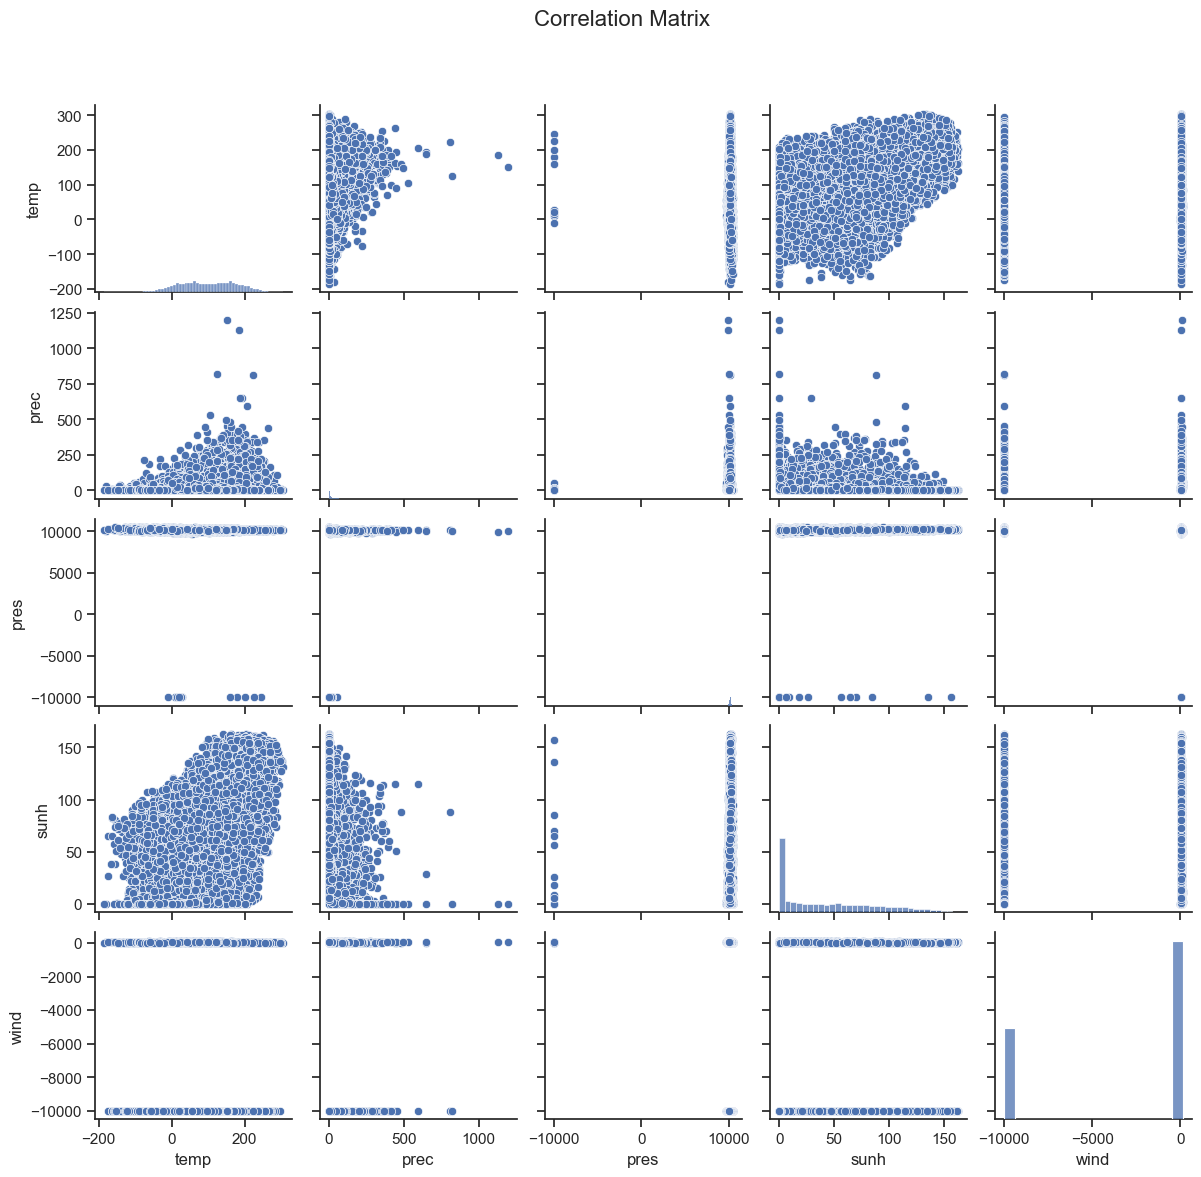

In [ ]:
sns.set_style('darkgrid')
sns.set(style="ticks", color_codes=True)
g = sns.PairGrid(df_copy[['temp', 'prec', 'pres', 'sunh', 'wind']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.fig.set_size_inches(12, 12)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation Matrix', fontsize=16)
plt.show()

### Correlation Findings

* There is a moderate positive correlation between temperature and sunshine duration (0.53), which suggests that as temperature increases, the duration of sunshine also tends to increase.
* There is also a weak positive correlation between temperature and wind speed (0.05), which suggests that there may be some tendency for temperature and wind speed to increase together, although the correlation is not strong.
* There is a weak negative correlation between precipitation amount and sea level pressure (-0.05), which suggests that there may be some tendency for precipitation and sea level pressure to move in opposite directions, although the correlation is not strong.
* The other correlations (temperature and sea level pressure, precipitation and temperature, precipitation and wind speed, sea level pressure and sunshine duration, and wind speed and sunshine duration) are very weak or close to zero.

These findings indicate that while there may be some association between these variables, further research is needed to establish a stronger relationship.

### Correlation Matrix
Here is a simpler approach to visualizing correlation matrix. The code snippet below uses a diverging color map with purple tones for negative values and green tones for positive values, and white for zero.

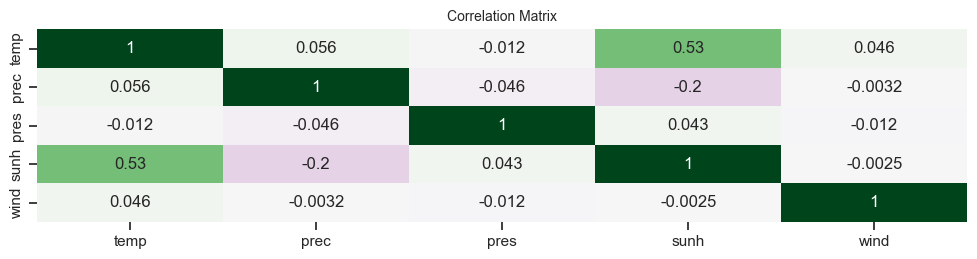

In [ ]:
# def pearson_corr(x, y):
#     n = len(x)
#     mean_x = np.mean(x)
#     mean_y = np.mean(y)
#     std_x = np.std(x, ddof=1)
#     std_y = np.std(y, ddof=1)
#     cov_xy = np.sum((x - mean_x) * (y - mean_y)) / (n - 1)
#     corr = cov_xy / (std_x * std_y)
#     return corr

# print(pearson_corr(df_copy['temp'], df_copy['prec']))

corr_matrix = df_copy[['temp', 'prec', 'pres', 'sunh', 'wind']].corr()

fig, ax = plt.subplots(figsize=(12, 2.5))
sns.heatmap(corr_matrix, annot=True, cmap='PRGn', cbar=False, center=0)
plt.title('Correlation Matrix', fontsize=10)
plt.show()

## Temperature Visualization Over Time

Just a visual play on depicting year median temperature in Berlin for each year from 1953 to 2022

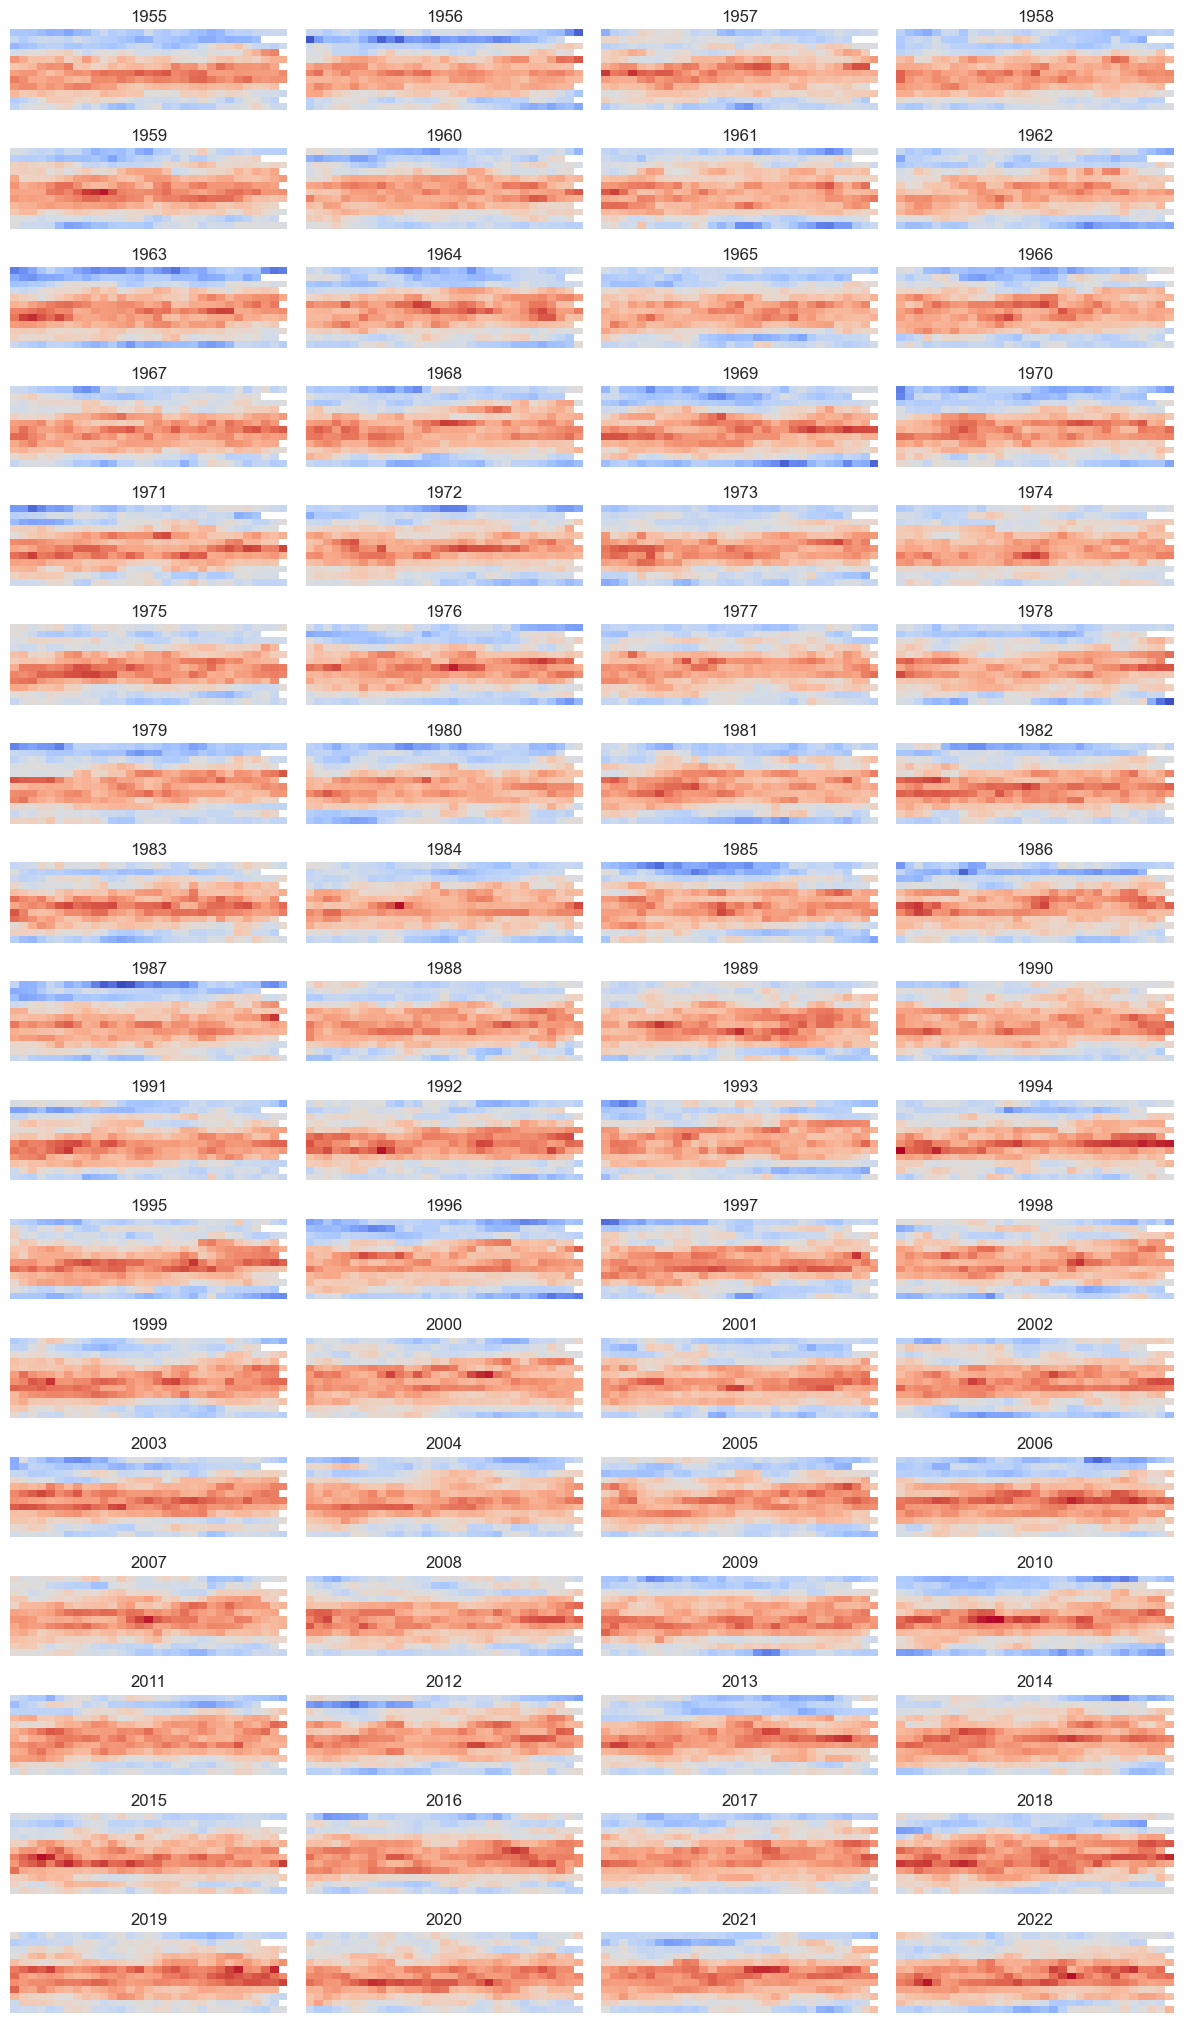

In [ ]:
years = range(1955, 2023)

num_plots = len(years)
num_rows, num_cols = divmod(num_plots, 4)
fig, axes = plt.subplots(nrows=num_rows+bool(num_cols), ncols=4, figsize=(12, 1.2*num_rows), sharex=True, sharey=True)

# Loop through the years and create a heatmap for each year
for i, year in enumerate(years):
    df_year = df[df['year'] == year]
    df_year_wide = df_year.pivot_table(index='month', columns='day', values='temp')
    ax = axes.flat[i]
    sns.heatmap(df_year_wide, cmap='coolwarm', cbar=False, ax=ax, vmin=df['temp'].min(), vmax=df['temp'].max())
    ax.set_title(f'{year}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_axis_off()

#cbar_ax = fig.add_axes([0.2, 0.1, 0.02, 0.9])
#fig.colorbar(ax.collections[0], cax=cbar_ax, label='Temperature (°C)', ticks=np.arange(-10, 30, 5), pad=0.05, shrink=0.8, aspect=20, extend='both')

fig.tight_layout()
plt.show()

### Export to PNG or GIF 🖼️ 
Exporting data to PNG or GIF may enhance the identification of trends and patterns that may not be immediately apparent from static manual inspection. By having the data in GIF format, it increases visual intuition about the trends and enables the implementation of further image processing techniques, or the loading of the data for machine learning purposes.

In [ ]:
import os
import imageio
# Create a directory to save the output images
output_dir = 'data/output/berlin'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Saves heatmap for each year in PNG
for year in range(1949, 2023):
    df_year = df[df['year'] == year]
    df_year_wide = df_year.pivot_table(index='month', columns='day', values='temp')
    sns.heatmap(df_year_wide, cmap='coolwarm', cbar=False)
    plt.title(f'{year}')
    plt.axis('off')
    # Save figure without border or padding
    plt.savefig(f'{output_dir}/{year}.png', bbox_inches='tight', pad_inches=0)
    plt.close()

# Creates the GIF out of the PNGs
dir_path = 'data/output/berlin'
file_list = os.listdir(dir_path)
file_list.sort()

images = []

for file_name in file_list:
    if file_name.endswith('.png'):
        file_path = os.path.join(dir_path, file_name)
        images.append(imageio.imread(file_path))

# Save the images as a GIF
imageio.mimsave('data/output/berlin/berlin_heatmap.gif', images, fps=2)

## Learning Resources

1. Academis by Dr. Kristian Rother [https://www.academis.eu/posts/data_analysis/climate_stripes.md](https://www.academis.eu/posts/data_analysis/climate_stripes.md)
2. European Climate Assessment and Dataset [https://www.ecad.eu/](https://www.ecad.eu/)
3. Seaborn Tutorial. [https://seaborn.pydata.org/tutorial/introduction](https://seaborn.pydata.org/tutorial/introduction)